PROBLEM STATEMENT: Classify rice image 

By: Prem S Rajanampalle, REI Intercollege, Dayalbagh, Agra

The dataset link: https://www.muratkoklu.com/datasets/vtdhnd09.php

# Table of contents:
1. Import dataset
2. View random image
3. Splitting folders 
4. Train-test dataset generation 
5. Model Creation 
7. Model Fitting 

## Import dataset

In [18]:
import os

for dirpath, dirnames, filenames in os.walk("Rice_Image_Dataset"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 5 directories and 1 images in 'Rice_Image_Dataset'
There are 0 directories and 15000 images in 'Rice_Image_Dataset\Arborio'
There are 0 directories and 15000 images in 'Rice_Image_Dataset\Basmati'
There are 0 directories and 15000 images in 'Rice_Image_Dataset\Ipsala'
There are 0 directories and 15000 images in 'Rice_Image_Dataset\Jasmine'
There are 0 directories and 15000 images in 'Rice_Image_Dataset\Karacadag'


In [19]:
import pathlib
import numpy as np

data_dir = pathlib.Path("Rice_Image_Dataset")
class_names = np.array(sorted(item.name for item in data_dir.iterdir()))
class_names = [c for c in class_names if c!= 'Rice_Citation_Request.txt']
class_names

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [20]:
len(class_names)

5

## View random image

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random 

def view_random_images(target_dir, target_class):
    target_folder = target_dir+target_class
    # Getting random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    # Read in image
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape: {img.shape}")
    
    return img

Image Shape: (250, 250, 3)


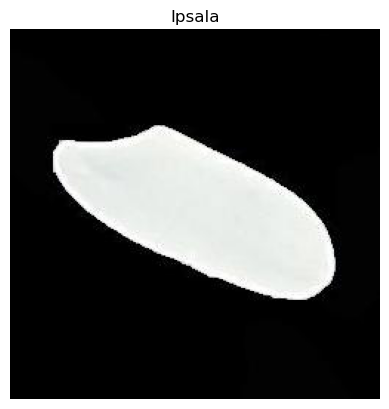

In [22]:
img = view_random_images("Rice_Image_Dataset/", "Ipsala")

## Split folders 

In [8]:
import splitfolders 

splitfolders.ratio("Rice_Image_Dataset/", output = "output_rice", seed = 1345, ratio = (0.8, 0.2))

Copying files: 75000 files [05:16, 237.32 files/s]


In [23]:
train_dir = "output_rice/train/"
test_dir = "output_rice/val/"

## Train-test generation 

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(1./255)
test_datagen = ImageDataGenerator(1./255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                   target_size = (224, 224),
                                                   batch_size = 32,
                                                   class_mode = "categorical")

test_generator = test_datagen.flow_from_directory(test_dir, 
                                                   target_size = (224, 224),
                                                   batch_size = 32,
                                                   class_mode = "categorical")

Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [25]:
test_generator.classes

array([0, 0, 0, ..., 4, 4, 4])

In [26]:
from sklearn import metrics
from tensorflow.keras.optimizers import Adadelta, Adagrad, Adam, RMSprop, SGD
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Train and test directories

## Model Creating 

In [27]:
# Model builder 

def model_builder(optimizer, activations):
    model = tf.keras.models.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = (224, 224, 3)),
        tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), padding = "same", activation = activation, kernel_initializer = "he_normal"),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),

        tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = "same", activation = activation, kernel_initializer="he_normal"),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),

        tf.keras.layers.Dropout(0.20),

        tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = activation, kernel_initializer="he_normal"),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),

        tf.keras.layers.Dropout(0.20),

        tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = activation, kernel_initializer="he_normal"),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),

        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation = activation, kernel_initializer = "he_normal"),
        tf.keras.layers.Dense(64, activation),
        tf.keras.layers.Dense(5, activation = "softmax")
    ])
    # Compile
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Fit the model
    model.fit(train_generator, 
              epochs = 15, 
              steps_per_epoch = len(test_generator), 
              validation_data = test_generator,
              validation_steps = len(test_generator))
    
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred = y_pred.argmax(axis = 1)
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix", cm)
    
    # Precision, recall, f1
    print("Precision: ", precision_score(y_true, y_pred, average = "weighted"))
    print("Recall: ", recall_score(y_true, y_pred, average = "weighted"))
    print("F1 Score: ", f1_score(y_true, y_pred, average = "weighted"))    
    
    # Compute mcc
    mcc = matthews_corrcoef(y_true, y_pred)
    print("MCC", mcc)
    
    
    ## evaluate the model
    #loss, accuracy = model.evaluate(test_generator, verbose=0)
    #y_true = []
    #y_pred = []
    #for x, y in test_generator:
        #y_true.extend(tf.argmax(y, axis=1).numpy())
       # y_pred.extend(tf.argmax(model.predict(x), axis=1).numpy())
    
    #f1 = f1_score(y_true, y_pred)
    #precision = precision_score(y_true, y_pred)
    #recall = recall_score(y_true, y_pred)
    #mcc = matthews_corrcoef(y_true, y_pred)
    
    return model

## Fitting the model

In [14]:
# Fit
# Test all permutations of optimizers and activations, and compute the accuracy and f1 score for each
optimizers = ['Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD']
activations = ['relu', 'tanh']
#metrics1 = ['accuracy', 'precision', 'recall', 'mcc']

for optimizer in optimizers:
    for activation in activations:
        print(f"Optimizer: {optimizer}, Activation: {activation}")
        model_builder(optimizer, activation)
        #print(metrics.classification_report(y_test, y_pred))
        # print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, MCC: {mcc:.4f}")

Optimizer: Adadelta, Activation: relu


C:\Users\hp\anaconda3\lib\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/15
469/469 [==============================] - 677s 1s/step - loss: 1.5570 - accuracy: 0.3455 - val_loss: 1.4339 - val_accuracy: 0.4439
Epoch 2/15
469/469 [==============================] - 689s 1s/step - loss: 1.2778 - accuracy: 0.4745 - val_loss: 1.2628 - val_accuracy: 0.5465
Epoch 3/15
469/469 [==============================] - 704s 2s/step - loss: 1.0633 - accuracy: 0.5705 - val_loss: 1.1006 - val_accuracy: 0.6658
Epoch 4/15
469/469 [==============================] - 722s 2s/step - loss: 0.9103 - accuracy: 0.6447 - val_loss: 0.9627 - val_accuracy: 0.7397
Epoch 5/15
469/469 [==============================] - 718s 2s/step - loss: 0.7849 - accuracy: 0.7026 - val_loss: 0.8561 - val_accuracy: 0.7612
Epoch 6/15
469/469 [==============================] - 693s 1s/step - loss: 0.7030 - accuracy: 0.7453 - val_loss: 0.7720 - val_accuracy: 0.8082
Epoch 7/15
469/469 [==============================] - 702s 1s/step - loss: 0.6223 - accuracy: 0.7781 - val_loss: 0.7111 - val_accuracy: 0.7959

C:\Users\hp\anaconda3\lib\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/15
469/469 [==============================] - 1234s 3s/step - loss: 1.4300 - accuracy: 0.4132 - val_loss: 1.2442 - val_accuracy: 0.5329
Epoch 2/15
469/469 [==============================] - 1407s 3s/step - loss: 1.1483 - accuracy: 0.6082 - val_loss: 1.0363 - val_accuracy: 0.6855
Epoch 3/15
469/469 [==============================] - 1218s 3s/step - loss: 0.9603 - accuracy: 0.7238 - val_loss: 0.8960 - val_accuracy: 0.7590
Epoch 4/15
469/469 [==============================] - 1187s 3s/step - loss: 0.8287 - accuracy: 0.7956 - val_loss: 0.8128 - val_accuracy: 0.7861
Epoch 5/15
469/469 [==============================] - 1273s 3s/step - loss: 0.7335 - accuracy: 0.8420 - val_loss: 0.7377 - val_accuracy: 0.8168
Epoch 6/15
469/469 [==============================] - 1164s 2s/step - loss: 0.6664 - accuracy: 0.8603 - val_loss: 0.6805 - val_accuracy: 0.8398
Epoch 7/15
469/469 [==============================] - 1149s 2s/step - loss: 0.6018 - accuracy: 0.8790 - val_loss: 0.6396 - val_accuracy:

C:\Users\hp\anaconda3\lib\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/15
469/469 [==============================] - 1094s 2s/step - loss: 0.4688 - accuracy: 0.8243 - val_loss: 0.3015 - val_accuracy: 0.9047
Epoch 2/15
469/469 [==============================] - 1090s 2s/step - loss: 0.2048 - accuracy: 0.9278 - val_loss: 0.2083 - val_accuracy: 0.9399
Epoch 3/15
469/469 [==============================] - 1160s 2s/step - loss: 0.1692 - accuracy: 0.9395 - val_loss: 0.2280 - val_accuracy: 0.9267
Epoch 4/15
469/469 [==============================] - 1090s 2s/step - loss: 0.1525 - accuracy: 0.9476 - val_loss: 0.2068 - val_accuracy: 0.9343
Epoch 5/15
469/469 [==============================] - 1097s 2s/step - loss: 0.1444 - accuracy: 0.9472 - val_loss: 0.2069 - val_accuracy: 0.9305
Epoch 6/15
469/469 [==============================] - 1131s 2s/step - loss: 0.1291 - accuracy: 0.9576 - val_loss: 0.2076 - val_accuracy: 0.9305
Epoch 7/15
469/469 [==============================] - 1235s 3s/step - loss: 0.1258 - accuracy: 0.9556 - val_loss: 0.2012 - val_accuracy:

C:\Users\hp\anaconda3\lib\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


469/469 [==============================] - 580s 1s/step - loss: 0.6049 - accuracy: 0.8256 - val_loss: 0.5342 - val_accuracy: 0.8115
Epoch 2/15
469/469 [==============================] - 610s 1s/step - loss: 0.2774 - accuracy: 0.9305 - val_loss: 0.4877 - val_accuracy: 0.8102
Epoch 3/15
469/469 [==============================] - 568s 1s/step - loss: 0.2095 - accuracy: 0.9459 - val_loss: 0.5249 - val_accuracy: 0.7723
Epoch 4/15
469/469 [==============================] - 639s 1s/step - loss: 0.1691 - accuracy: 0.9579 - val_loss: 0.4641 - val_accuracy: 0.8002
Epoch 5/15
469/469 [==============================] - 717s 2s/step - loss: 0.1402 - accuracy: 0.9655 - val_loss: 0.4775 - val_accuracy: 0.7941
Epoch 6/15
469/469 [==============================] - 765s 2s/step - loss: 0.1213 - accuracy: 0.9696 - val_loss: 0.3861 - val_accuracy: 0.8395
Epoch 7/15
469/469 [==============================] - 593s 1s/step - loss: 0.1012 - accuracy: 0.9763 - val_loss: 0.4384 - val_accuracy: 0.8130
Epoch 8/15

C:\Users\hp\anaconda3\lib\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


469/469 [==============================] - 581s 1s/step - loss: 0.2066 - accuracy: 0.9260 - val_loss: 0.1124 - val_accuracy: 0.9611
Epoch 2/15
469/469 [==============================] - 682s 1s/step - loss: 0.1172 - accuracy: 0.9586 - val_loss: 0.0967 - val_accuracy: 0.9671
Epoch 3/15
469/469 [==============================] - 632s 1s/step - loss: 0.1007 - accuracy: 0.9666 - val_loss: 0.0801 - val_accuracy: 0.9734
Epoch 4/15
469/469 [==============================] - 702s 1s/step - loss: 0.0790 - accuracy: 0.9727 - val_loss: 0.1281 - val_accuracy: 0.9553
Epoch 5/15
469/469 [==============================] - 619s 1s/step - loss: 0.0554 - accuracy: 0.9825 - val_loss: 0.0622 - val_accuracy: 0.9795
Epoch 6/15
469/469 [==============================] - 567s 1s/step - loss: 0.0449 - accuracy: 0.9848 - val_loss: 0.0356 - val_accuracy: 0.9901
Epoch 7/15
469/469 [==============================] - 573s 1s/step - loss: 0.0386 - accuracy: 0.9873 - val_loss: 0.0385 - val_accuracy: 0.9887
Epoch 8/15

C:\Users\hp\anaconda3\lib\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/15
469/469 [==============================] - 711s 2s/step - loss: 0.2004 - accuracy: 0.9354 - val_loss: 0.0761 - val_accuracy: 0.9739
Epoch 2/15
469/469 [==============================] - 723s 2s/step - loss: 0.0692 - accuracy: 0.9787 - val_loss: 0.0519 - val_accuracy: 0.9846
Epoch 3/15
469/469 [==============================] - 725s 2s/step - loss: 0.0614 - accuracy: 0.9781 - val_loss: 0.0480 - val_accuracy: 0.9833
Epoch 4/15
469/469 [==============================] - 625s 1s/step - loss: 0.0588 - accuracy: 0.9813 - val_loss: 0.0374 - val_accuracy: 0.9886
Epoch 5/15
469/469 [==============================] - 658s 1s/step - loss: 0.0639 - accuracy: 0.9784 - val_loss: 0.0403 - val_accuracy: 0.9877
Epoch 6/15
469/469 [==============================] - 752s 2s/step - loss: 0.0534 - accuracy: 0.9821 - val_loss: 0.0368 - val_accuracy: 0.9883
Epoch 7/15
469/469 [==============================] - 671s 1s/step - loss: 0.0578 - accuracy: 0.9804 - val_loss: 0.0528 - val_accuracy: 0.9813

C:\Users\hp\anaconda3\lib\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


469/469 [==============================] - 619s 1s/step - loss: 0.2478 - accuracy: 0.9158 - val_loss: 0.1081 - val_accuracy: 0.9646
Epoch 2/15
469/469 [==============================] - 617s 1s/step - loss: 0.1202 - accuracy: 0.9584 - val_loss: 0.1356 - val_accuracy: 0.9489
Epoch 3/15
469/469 [==============================] - 612s 1s/step - loss: 0.1088 - accuracy: 0.9631 - val_loss: 0.1368 - val_accuracy: 0.9514
Epoch 4/15
469/469 [==============================] - 607s 1s/step - loss: 0.1047 - accuracy: 0.9636 - val_loss: 0.0928 - val_accuracy: 0.9687
Epoch 5/15
469/469 [==============================] - 608s 1s/step - loss: 0.0939 - accuracy: 0.9689 - val_loss: 0.1023 - val_accuracy: 0.9643
Epoch 6/15
469/469 [==============================] - 606s 1s/step - loss: 0.0884 - accuracy: 0.9702 - val_loss: 0.0768 - val_accuracy: 0.9763
Epoch 7/15
469/469 [==============================] - 606s 1s/step - loss: 0.0799 - accuracy: 0.9714 - val_loss: 0.0674 - val_accuracy: 0.9769
Epoch 8/15

C:\Users\hp\anaconda3\lib\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


469/469 [==============================] - 628s 1s/step - loss: 0.2346 - accuracy: 0.9175 - val_loss: 0.0908 - val_accuracy: 0.9678
Epoch 2/15
469/469 [==============================] - 630s 1s/step - loss: 0.0754 - accuracy: 0.9745 - val_loss: 0.0376 - val_accuracy: 0.9885
Epoch 3/15
469/469 [==============================] - 631s 1s/step - loss: 0.0618 - accuracy: 0.9804 - val_loss: 0.0408 - val_accuracy: 0.9873
Epoch 4/15
469/469 [==============================] - 629s 1s/step - loss: 0.0551 - accuracy: 0.9831 - val_loss: 0.0355 - val_accuracy: 0.9901
Epoch 5/15
469/469 [==============================] - 630s 1s/step - loss: 0.0442 - accuracy: 0.9861 - val_loss: 0.0565 - val_accuracy: 0.9833
Epoch 6/15
469/469 [==============================] - 630s 1s/step - loss: 0.0418 - accuracy: 0.9862 - val_loss: 0.0270 - val_accuracy: 0.9918
Epoch 7/15
469/469 [==============================] - 631s 1s/step - loss: 0.0350 - accuracy: 0.9876 - val_loss: 0.0388 - val_accuracy: 0.9891
Epoch 8/15

C:\Users\hp\anaconda3\lib\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


469/469 [==============================] - 584s 1s/step - loss: 0.3959 - accuracy: 0.8462 - val_loss: 0.3366 - val_accuracy: 0.8755
Epoch 2/15
469/469 [==============================] - 40391s 86s/step - loss: 0.1600 - accuracy: 0.9433 - val_loss: 0.2560 - val_accuracy: 0.9148
Epoch 3/15
469/469 [==============================] - 676s 1s/step - loss: 0.1264 - accuracy: 0.9568 - val_loss: 0.2131 - val_accuracy: 0.9303
Epoch 4/15
469/469 [==============================] - 669s 1s/step - loss: 0.1097 - accuracy: 0.9622 - val_loss: 0.1887 - val_accuracy: 0.9364
Epoch 5/15
469/469 [==============================] - 581s 1s/step - loss: 0.1060 - accuracy: 0.9635 - val_loss: 0.1683 - val_accuracy: 0.9473
Epoch 6/15
469/469 [==============================] - 552s 1s/step - loss: 0.1019 - accuracy: 0.9646 - val_loss: 0.1710 - val_accuracy: 0.9503
Epoch 7/15
469/469 [==============================] - 606s 1s/step - loss: 0.0921 - accuracy: 0.9677 - val_loss: 0.1419 - val_accuracy: 0.9565
Epoch 8

C:\Users\hp\anaconda3\lib\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


469/469 [==============================] - 643s 1s/step - loss: 0.3660 - accuracy: 0.8857 - val_loss: 0.7663 - val_accuracy: 0.6669
Epoch 2/15
469/469 [==============================] - 655s 1s/step - loss: 0.1544 - accuracy: 0.9562 - val_loss: 0.7902 - val_accuracy: 0.6631
Epoch 3/15
469/469 [==============================] - 594s 1s/step - loss: 0.1194 - accuracy: 0.9628 - val_loss: 0.8328 - val_accuracy: 0.6587
Epoch 4/15
469/469 [==============================] - 585s 1s/step - loss: 0.1050 - accuracy: 0.9666 - val_loss: 0.8379 - val_accuracy: 0.6615
Epoch 5/15
469/469 [==============================] - 613s 1s/step - loss: 0.1023 - accuracy: 0.9657 - val_loss: 0.5787 - val_accuracy: 0.7643
Epoch 6/15
469/469 [==============================] - 561s 1s/step - loss: 0.0934 - accuracy: 0.9674 - val_loss: 0.6130 - val_accuracy: 0.7525
Epoch 7/15
469/469 [==============================] - 658s 1s/step - loss: 0.0880 - accuracy: 0.9710 - val_loss: 0.5083 - val_accuracy: 0.7951
Epoch 8/15

with adam optimizer and relu activation, we achieved ~99.6 %. 